In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xr/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('poster')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

## Define Functions

In [2]:
def gradRichardson(airTemp, windSpd, mHeight):
    '''
    airTemp = air temperature (K) corresponding to heights N
    windSpd = wind speeds (m s^-1) corresponding to heights N
    mHeight = measurement heights (m) of wind and air temperature
    '''
# -------------------------------------------------------------------------------------------------------
    #########
    # Sub-function
    def logGrad(x1, x2, z1, z2):
        # Log gradient function
        mid = np.exp((np.log(z1) + np.log(z2)) / 2)
        grad = 1 / mid * ((x2 - x1)/(np.log(z2) - np.log(z1)))
        return grad,mid
# -------------------------------------------------------------------------------------------------------

    #########
    # Constants/Parameters
    g = 9.81                                # gravitational acceleration (m s^-2)
    numL = mHeight.size                     # Number of layers
    
    #########
    # Difference each heigh using logGrad
    gradWind = np.zeros(numL-1)             # Gradient in wind
    zMid = np.zeros(numL-1)                 # Log-averaged height beetween layers
    gradTheta = np.zeros(numL-1)            # Gradient in virtual temperature
    thetaMid = np.zeros(numL-1)             # "virtual" temperature at the mid-point between levels
    
    for k in np.arange(0,numL-1):
        (gradWind[k], zMid[k]) = logGrad(windSpd[k], windSpd[k + 1], mHeight[k], mHeight[k + 1])
        (gradTheta[k], zMid[k]) = logGrad(airTemp[k], airTemp[k+1], mHeight[k], mHeight[k+1])
        thetaMid[k] = np.exp((np.log(airTemp[k]) + np.log(airTemp[k + 1])) / 2)

    ## Calculate the gradient Richardson Number
    gradRi = g / thetaMid * (gradTheta / gradWind**2)
    gradRiMean = np.mean(gradRi)
    return(gradRi, gradRiMean)

## Notes
Calculating z0 and the Obukhov length using the gradient Ri number

###### Gradients
Calculate the gradients in $u$ and $\theta$ between each layer using the expression:

$\frac{\Delta u}{\Delta z} = \frac{1}{z_m} \frac{u_{z2} - u_{z1}}{ln(z2)-ln(z1)} $

where $z_m$ is the average of the log heights $\frac{ln(z1) + ln(z2)}{2}$ and $u$ can be exchanged with $\theta$

###### gradient Richardson Number
$Ri = \frac{-d\theta}{dz} \frac{du}{dz}^{-2} $

$ b = g\theta_m/\theta $

#### Friction Velocity
First finding the friction velocity, ($u_*$)

Given that $\Phi_h = \Phi_M^2 = 1-16 \frac{z}{L} $ (e.g., $\gamma_1 = 16$)

Equation 6.2 from the notes
$kz/u_{*} \frac{du}{dz} = \Phi_m(\frac{z}{L})$

Solve for $u_{*}$:

$kz/\Phi_m(\frac{z}{L}) \frac{du}{dz} = u_{*}$

#### Surface Roughness
Finding the surface roughness using equation 6.14 from the class notes.

$u(z) = \frac{u_*}{k} (\ln( \frac{z}{z_0}) - \Psi_m(\frac{z}{L})) $ (eq. 6.14)

where $\Psi_m = log(\frac{1+x^2}{2}\frac{1+x}{2}^2) - 2 \tan^-1(x) + \pi/2$

and $x = (1-\gamma_1 \frac{z}{L})^{1/4}$

solving for $z_0$

$z_0 = z/ \exp(\frac{k u(z)}{u_*} + \Psi_m)$ 

In [3]:
# -------------------------------------------------------------------------------------------------------
# Open netcdfs
# -------------------------------------------------------------------------------------------------------
os.chdir(dirData)
Atower = xr.open_dataset('SCP.Atower.netcdf')
Ctower = xr.open_dataset('SCP.Ctower.netcdf')
Mtower = xr.open_dataset('SCP.Mtower.netcdf')
soilObs = xr.open_dataset('SCP.soil_obs.netcdf')
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# -------------------------------------------------------------------------------------------------------
# Convert byte literals to python strings
# -------------------------------------------------------------------------------------------------------
Atower['station'] = [stat.decode("utf-8") for stat in Atower.station.values]

In [4]:
aggFlag = False
# -------------------------------------------------------------------------------------------------------
# Aggregate to half and hour
# -------------------------------------------------------------------------------------------------------
if aggFlag:
    # 30 minute averages of fluxes
    fluxObs_30m = fluxObs.resample(freq='30Min',how='mean',dim='time')
    radObs_30m = radObs.resample(freq='30Min',how='mean',dim='time')
    soilObs_30m = soilObs.resample(freq='30Min',how='mean',dim='time')

    # Mean ground heat flux @ both sites
    soilObs_30m['Gsfc'] = xr.concat([soilObs_30m.Gsfc_c,\
                                        soilObs_30m.Gsfc_g],dim='site').mean(dim='site')
    soilObs_30m['Gsoil_5cm'] = xr.concat([soilObs_30m.Gsoil_5cm_c,\
                                        soilObs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')
    # Save 30min averages
    os.chdir(dirData)
    fluxObs_30m.to_netcdf('SCP.flux_obs_30m.netcdf')
    radObs_30m.to_netcdf('SCP.rad_obs_30m.netcdf')
    soilObs_30m.to_netcdf('SCP.soil_obs_30m.netcdf')
    
# -------------------------------------------------------------------------------------------------------
# Load 30min averages
# -------------------------------------------------------------------------------------------------------
elif not aggFlag:
    os.chdir(dirData)
    fluxObs_30m = xr.open_dataset('SCP.flux_obs_30m.netcdf')
    radObs_30m = xr.open_dataset('SCP.rad_obs_30m.netcdf')
    soilObs_30m = xr.open_dataset('SCP.soil_obs_30m.netcdf')

### M Tower

In [5]:
# -------------------------------------------------------------------------------------------------------
# Surface temperature from upwelling longwave
# -------------------------------------------------------------------------------------------------------
sigma = 5.67*10**-8.  # Stefan-Boltzmann constant
Tsfc = (radObs.Rlw_out/sigma)**(1./4.)
# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc-273.15)

# -------------------------------------------------------------------------------------------------------
# Wind speed vectors
# -------------------------------------------------------------------------------------------------------
Mtower['UBar_15m'] = (('time'), (Mtower.U_15m_M**2 + Mtower.V_15m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
Mtower['UBar_2m'] = (('time'), (Mtower.u_2m_M**2 + Mtower.v_2m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_2m > 10] = np.nan

# -------------------------------------------------------------------------------------------------------
# Bulk Richardson Number
# -------------------------------------------------------------------------------------------------------
RiBulk_15m_M,_,_ = turbpy.bulkRichardson(Mtower.T_15m_M + 273.15, Mtower.Tsfc + 273.15, Mtower.UBar_15m, 15.)
Mtower['RiBulk_15m'] = RiBulk_15m_M
RiBulk_2m_M,_,_ = turbpy.bulkRichardson(Mtower.T_1m_M + 273.15, Mtower.Tsfc + 273.15, Mtower.UBar_2m, 1.)
Mtower['RiBulk_2m'] = RiBulk_2m_M

### A Towers

In [6]:
# -------------------------------------------------------------------------------------------------------
# Wind speed vectors
# -------------------------------------------------------------------------------------------------------
Atower['UBar_5m'] = (('time', 'station'), (Atower.U_0_5m**2 + Atower.V_0_5m**2)**(1. / 2.))
Atower.UBar_5m.values[np.nonzero(np.isnan(Atower.UBar_5m.values) |
                                 (Atower.UBar_5m.values > 20))] = np.nan
Atower['UBar_1m'] = (('time', 'station'), (Atower.u_1m**2 + Atower.v_1m**2)**(1. / 2.))
Atower.UBar_1m.values[np.nonzero(np.isnan(Atower.UBar_5m.values) |
                                 (Atower.UBar_1m.values > 20))] = np.nan

# -------------------------------------------------------------------------------------------------------
# Bulk Richardson Number
# -------------------------------------------------------------------------------------------------------
RiBulk_5m_A,_,_ = turbpy.bulkRichardson(Atower.T_0_5m + 273.15, Mtower.Tsfc + 273.15, Atower.UBar_5m, 5.)
Atower['RiBulk_5m'] = RiBulk_5m_A

RiBulk_1m_A,_,_ = turbpy.bulkRichardson(Atower.T_1m + 273.15, Mtower.Tsfc + 273.15, Atower.UBar_1m, 1.)
Atower['RiBulk_1m'] = RiBulk_1m_A

# Air temperature variations
- Mtower observations at 5 minute intervals

In [7]:
Mtower_hour_mean = Mtower.T_15m_M.resample(how='mean',freq='H',dim='time')
Mtower_hour_std = Mtower.T_15m_M.resample(how='std',freq='H',dim='time')

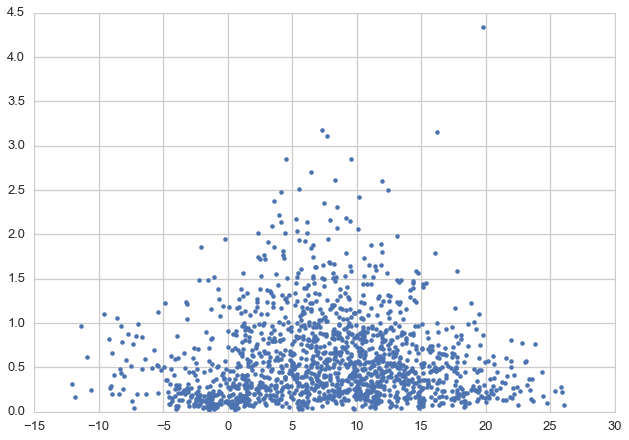

In [6]:
plt.plot(Mtower_hour_mean,Mtower_hour_std,'.')

## Boundary Layer Obs Analysis

In [9]:
# ########
# # Gradient Richardson Number
# nTempFields = ['T_1m_M', 'T_2_5m_M', 'T_4m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
# Mtower.
# nWindFields = ['']
# heights = [1.,2.5,4.,6.,8.,15.]
# for t in Mtower.time:
#     nTemp = [Mtower[ntf].sel(time=t).values for ntf in nTempFields]
#     _,RiGrad = gradRichardson(,Mtower.Tsfc+273.15,Mtower.UBar_15m,15.)

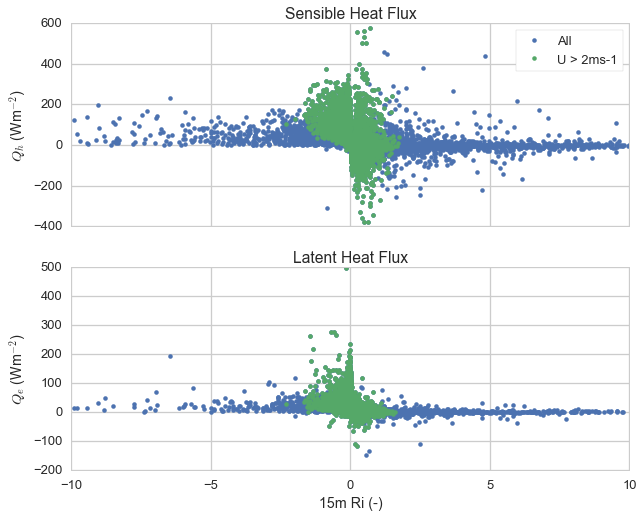

In [10]:
Rmin = -10
Rmax = 10
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Index of high wind speeds (Ubar > 2ms-1)
uInd = np.nonzero( (Mtower.UBar_15m > 2.).values)

# Sensible heat flux
ax = axes[0]
ax.plot(RiBulk_15m,fluxObs.w_tc__10m_M,'.',label='All')
ax.plot(RiBulk_15m[uInd],fluxObs.w_tc__10m_M[uInd],'.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
ax.plot(RiBulk_15m,fluxObs.w_h2o__10m_M,'.',label='All')
ax.plot(RiBulk_15m[uInd],fluxObs.w_h2o__10m_M[uInd],'.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')
ax.set_xlabel('15m Ri (-)')
ax.set_title('Latent Heat Flux')

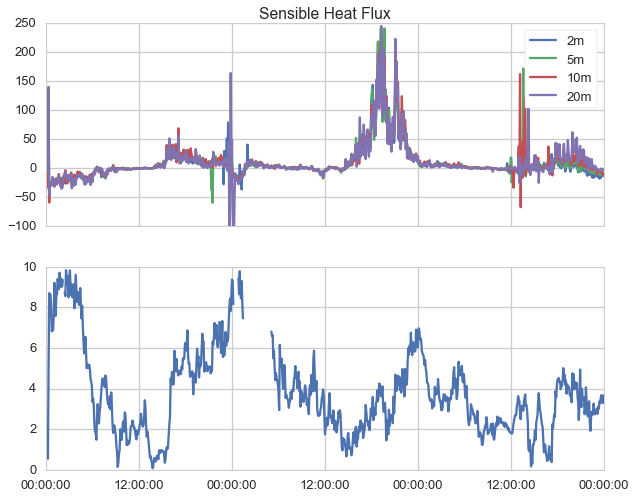

In [11]:
d1 = datetime(2012,10,24)
d2 = datetime(2012,10,27)
Rmin = -10
Rmax = 10
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Index of high wind speeds (Ubar > 2ms-1)
uInd = np.nonzero( (Mtower.UBar_15m > 2.).values)

# Sensible heat flux
ax = axes[0]
ax.plot(Mtower.time,fluxObs.w_tc__2m_M,label='2m')
ax.plot(Mtower.time,fluxObs.w_tc__5m_M,label='5m')
ax.plot(Mtower.time,fluxObs.w_tc__10m_M,label='10m')
ax.plot(Mtower.time,fluxObs.w_tc__20m_M,label='20m')
ax.set_ylim(-100,250)
ax.set_xlim(d1,d2)
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
ax.plot(Mtower.time,Mtower.UBar_15m)

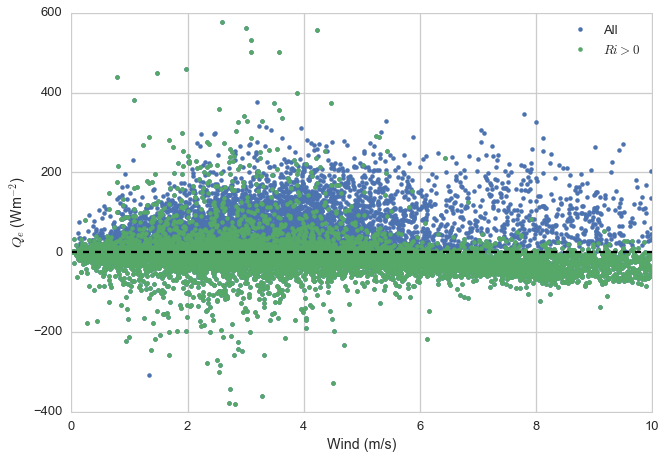

In [12]:
plt.plot(Mtower.UBar_15m,fluxObs.w_tc__10m_M,'.',label='All')
plt.plot(Mtower.UBar_15m.where(Mtower.RiBulk_15m > 0),fluxObs.w_tc__10m_M.where(Mtower.RiBulk_15m > 0),\
         '.',label='$Ri > 0$')
plt.plot([0, 10],[0,0],'k--')
ax = plt.gca()
ax.set_xlabel('Wind (m/s)')
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')
ax.legend()

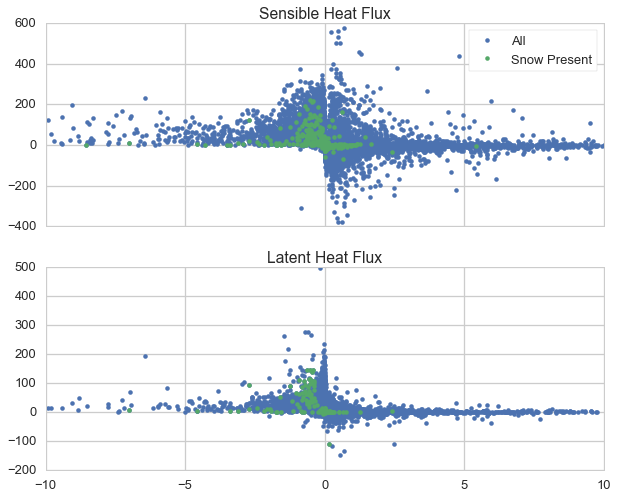

In [13]:
d1 = datetime(2012,10,24)
d2 = datetime(2012,10,27)

Rmin = -10
Rmax = 10

fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

# Sensible heat flux
ax = axes[0]
ax.plot(Mtower.RiBulk_15m,fluxObs.w_tc__10m_M,'.',label='All')
ax.plot(Mtower.RiBulk_15m.sel(time=slice(d1,d2)),fluxObs.w_tc__10m_M.sel(time=slice(d1,d2)),\
        '.',label='Snow Present')
ax.set_xlim(Rmin,Rmax)
ax.legend(frameon=True)
ax.set_title('Sensible Heat Flux')

ax = axes[1]
ax.plot(Mtower.RiBulk_15m,fluxObs.w_h2o__10m_M,'.',label='All')
ax.plot(Mtower.RiBulk_15m.sel(time=slice(d1,d2)),fluxObs.w_h2o__10m_M.sel(time=slice(d1,d2)),\
        '.',label='U > 2ms-1')
ax.set_xlim(Rmin,Rmax)
ax.set_title('Latent Heat Flux')

# AMS Boundary Layer
Attempting to recreate figures presented at the AMS Boundary Layer and Turbulence Conference

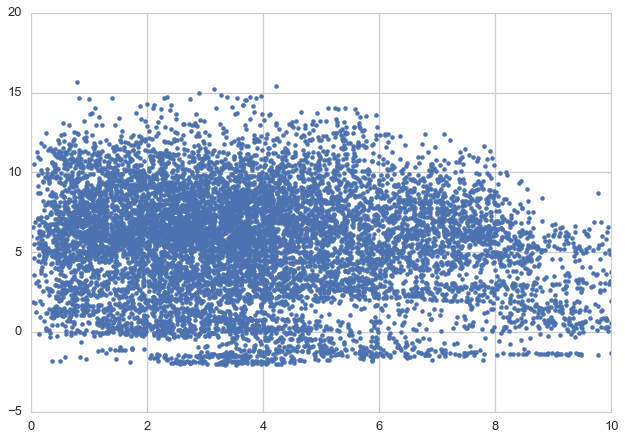

In [14]:
plt.plot(Mtower.UBar_15m.where(radObs.Rsw_in <= 10),\
         Mtower.T_15m_M.where(radObs.Rsw_in <= 10)-Mtower.Tsfc.where(radObs.Rsw_in <= 10),'.')

### From AMS BL conference
- presenter (session 2a on Monday) shows an S-shape relationship between wind speed and delta-T at 10m. I don't have anything anywhere close to resembling that @ SNQ.

(-10, 30)

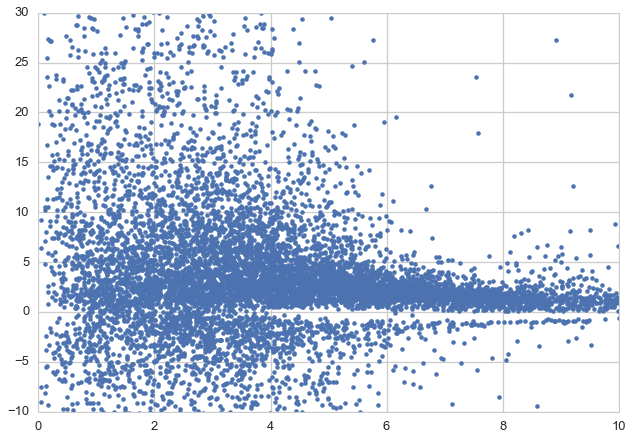

In [15]:
plt.plot(Mtower.UBar_15m.where(radObs.Rsw_in <= 10),\
         (radObs.Rlw_in-radObs.Rlw_out).where(radObs.Rsw_in <= 10)/fluxObs.w_tc__5m_M.where(radObs.Rsw_in <= 10),'.')
plt.gca().set_ylim(-10,30)

### Regimes of SBL
- left of ~6m/s has a turbulent boundary layer
- right of ~6m/s has a radiatively cooling boundary layer
- negative values are weird
- robust at several different heights that I tested arbitrarily

(-5, 15)

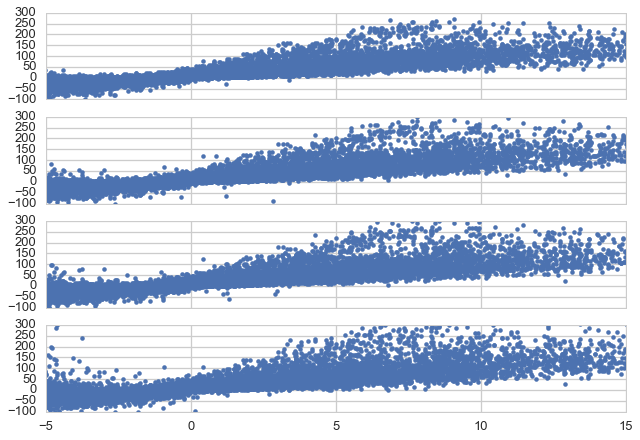

In [16]:
fig, axes = plt.subplots(4,1,sharex=True)

ax = axes[0]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__2m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[1]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__4m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[2]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__5m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)

ax = axes[3]
ax.plot(Mtower.Tsfc-Mtower.T_15m_M,fluxObs.w_tc__10m_M,'.')
ax.set_ylim(-100,300)
ax.set_xlim(-5,15)


(-200, 300)

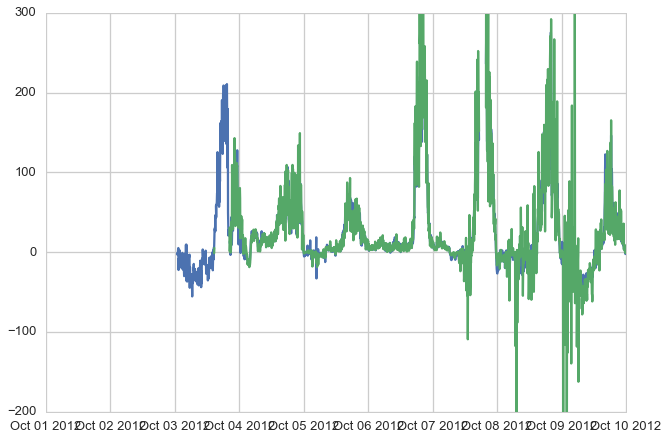

In [17]:
plt.plot(fluxObs.time,fluxObs.w_tc__2m_M)
plt.plot(fluxObs.time,fluxObs.w_tc__20m_M)
ax = plt.gca()
ax.set_xlim(datetime(2012,10,1),datetime(2012,10,10))
ax.set_ylim(-200,300)

## Do counter-gradient fluxes exist?
- previous work using this site did not use the correct sign for the latent and sensible heat flux.
- This section is checking for the presence of counter-gradient fluxes

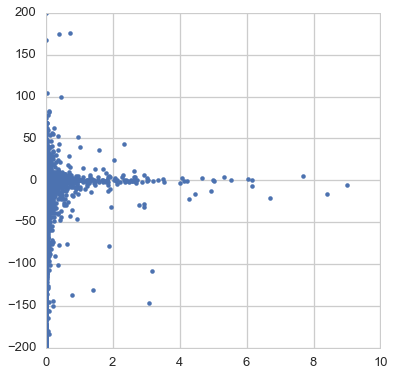

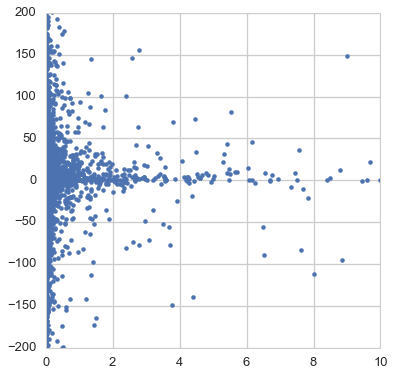

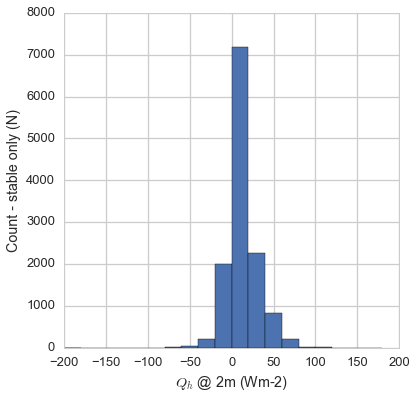

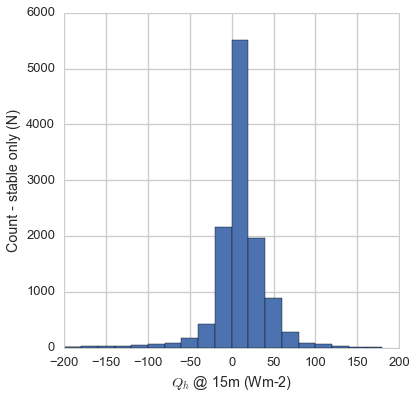

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(Mtower.RiBulk_2m, -fluxObs.w_h2o__1m_M, '.')
ax.set_xlim(0,10)
ax.set_ylim(-200,200)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(Mtower.RiBulk_2m, -fluxObs.w_tc__20m_M, '.')
ax.set_xlim(0,10)
ax.set_ylim(-200,200)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(-fluxObs.w_tc__2m_M[(Mtower.RiBulk_2m.values > 0)
                            & (~np.isnan(Mtower.RiBulk_2m)).values],
        bins=np.arange(-200,200,20));
ax.set_xlabel('$Q_h$ @ 2m (Wm-2)')
ax.set_ylabel('Count - stable only (N)')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(-fluxObs.w_tc__10m_M[(Mtower.RiBulk_15m.values > 0)
                             & (~np.isnan(Mtower.RiBulk_15m)).values
                             & (~np.isnan(fluxObs.w_tc__10m_M)).values],
        bins=np.arange(-200,200,20));
ax.set_xlabel('$Q_h$ @ 15m (Wm-2)')
ax.set_ylabel('Count - stable only (N)')


Good! Yay! There are counter gradient fluxes. Less than before, but there they are!

In [27]:
print((fluxObs['w_tc__10m_M'].where(Mtower.RiBulk_15m > 0) > 0).mean(dim='time'))
print((fluxObs['w_tc__2m_M'].where(Mtower.RiBulk_2m > 0) > 0).mean(dim='time'))

<xarray.DataArray ()>
array(0.15123456790123457)
Coordinates:
    altitude   float64 1.645e+03
    station    |S6 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
<xarray.DataArray ()>
array(0.11048418209876543)
Coordinates:
    altitude   float64 1.645e+03
    station    |S6 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81


## How does stability between the two levels compare?
- Answer: its a scatter shot! But the signs are aligned

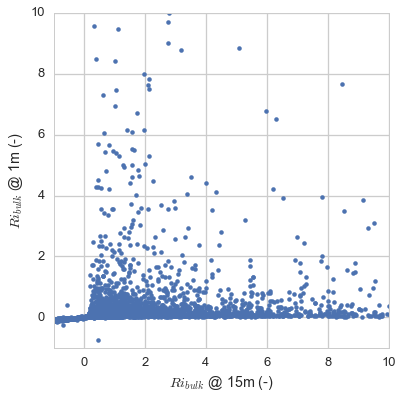

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(Mtower.RiBulk_15m,Mtower.RiBulk_2m,'.')
ax.set_xlim(-1,10)
ax.set_ylim(-1,10)
ax.set_xlabel('$Ri_{bulk}$ @ 15m (-)')
ax.set_ylabel('$Ri_{bulk}$ @ 1m (-)')

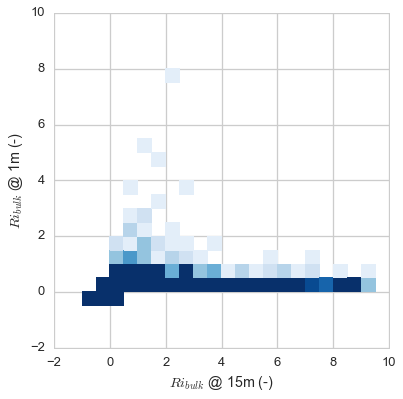

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmin = 1
cmax = 20
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)
H, xedges, yedges = np.histogram2d(Mtower.RiBulk_15m, Mtower.RiBulk_2m,
                                   bins=(np.arange(-1,10,.5),np.arange(-1,10,.5)))
H = np.ma.masked_array(H, H < cmin+dcol)
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)


ax.grid()
ax.set_xlabel('$Ri_{bulk}$ @ 15m (-)')
ax.set_ylabel('$Ri_{bulk}$ @ 1m (-)')

## Using a local potential temperature instead of absolute temperature

From Mahrt (2004):  
> In some formulations, the potential temperatures are replaced by actual tem- peratures (T ), which can lead to significant errors in stable conditions.  

He then transforms temperature to a local potential temperature, $\theta$, through the following:  
    $ \theta = T(z) + 0.01z $


**References:**  
Mahrt, L., and D. Vickers (2004), Bulk formulation of the surface heat flux, Boundary-Layer Meteorol., 110(3), 357–379

### M Tower

In [8]:
# Array of temperature fields in Mtower DataSet along with observation heights
towerNames = Mtower.data_vars
temperatureFields = [fieldNames for fieldNames in towerNames if 'T_' in fieldNames]
temperatureHeights = np.zeros(np.size(temperatureFields))
for n, tfields in enumerate(temperatureFields):
    strInd = [pos for pos, char in enumerate(tfields) if char == '_']
    temperatureHeights[n] = float(tfields[strInd[-2]+1:strInd[-1]-1])

    
temperatureFields = [tFields for (tHeights, tFields) in sorted(zip(temperatureHeights, temperatureFields))]
temperatureHeights = [tHeights for (tHeights, tFields) in sorted(zip(temperatureHeights, temperatureFields))]

In [9]:
# Convert to local potential temperature
thetaFields = []
for tz, tf in zip(temperatureHeights, temperatureFields):
    thetaFields.append('theta'+tf[1:])
    Mtower['theta'+tf[1:]] = Mtower[tf] + 0.01 * tz

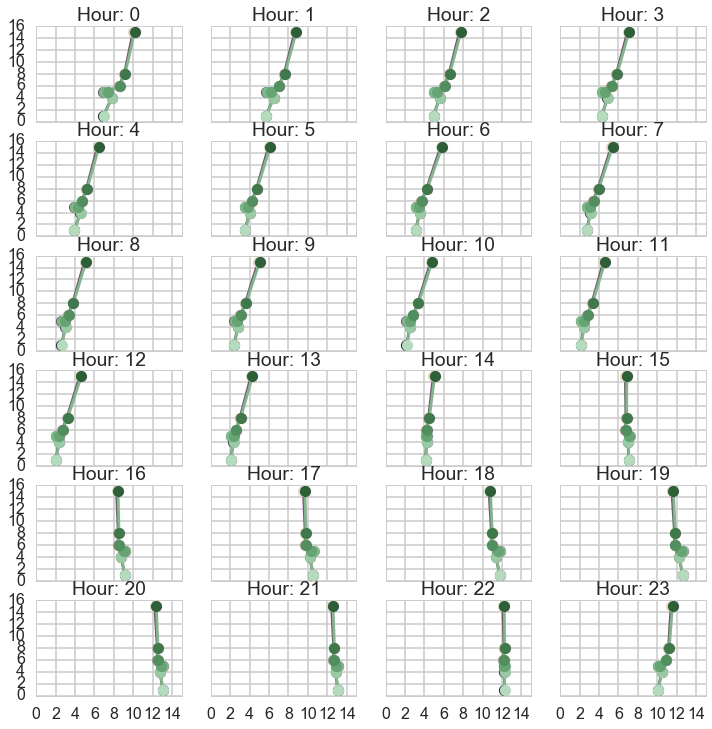

In [10]:
# How do these temperatures vary with height and time of day on average?
fig, axes = plt.subplots(6,4,figsize=(12,12),sharex='col',sharey='row')
axes = axes.flatten()
pal1 = sns.cubehelix_palette(np.size(temperatureHeights), reverse=True)
pal2 = sns.cubehelix_palette(np.size(temperatureHeights), start=2, rot=0, dark=.3, light=.8)
hour = np.arange(0,24)

for n,h in enumerate(hour):
    ax = axes[n]
    # Temperature with height
    vals = [Mtower[tf].sel(time=Mtower['time.hour'] == h).mean(dim='time') for tf in temperatureFields]    
    ax.plot(vals, temperatureHeights, color=pal1[2])
    # Color individual points
    for ind, tFields in enumerate(temperatureFields):    
        ax.plot(Mtower[tFields].sel(time=Mtower['time.hour'] == h).mean(dim='time'),
                temperatureHeights[ind],
                'o', color=pal1[ind])
   
    # Pot temp
    vals = [Mtower[tf].sel(time=Mtower['time.hour'] == h).mean(dim='time') for tf in thetaFields]    
    ax.plot(vals, temperatureHeights, color=pal2[2])
    # Color individual points
    for ind, tFields in enumerate(thetaFields):    
        ax.plot(Mtower[tFields].sel(time=Mtower['time.hour'] == h).mean(dim='time'),
                temperatureHeights[ind],
                'o', color=pal2[ind])
    
    ax.set_title('Hour: ' + str(h))
    ax.set_xlim(0, 15)


### Notes:
Using a "local" potential temperature has an almost impreciptible impact. _Maybe_ the correction might matter at the evening/morning transition.

An impact that is clear is that the 5m temperature sensors are significantly different than the other sensors. This reinforces the need of a slide showing all sensors (i.e. type) w/ height.

In [11]:
# -------------------------------------------------------------------------------------------------------
# Bulk Richardson Number using theta
# -------------------------------------------------------------------------------------------------------
RiBulk_15m_theta, _, _ = turbpy.bulkRichardson(Mtower.theta_15m_M + 273.15,
                                               Mtower.Tsfc + 273.15, Mtower.UBar_15m, 15.)
RiBulk_2m_theta, _, _ = turbpy.bulkRichardson(Mtower.theta_1m_M + 273.15,
                                              Mtower.Tsfc + 273.15, Mtower.UBar_2m, 15.)


In [16]:
plt.hist([RiBulk_15m[(~np.isnan(RiBulk_15m)) & (RiBulk_15m < 100)], 
          RiBulk_15m_theta[(~np.isnan(RiBulk_15m_theta)) & (RiBulk_15m_theta < 100)]],
          bins=np.arange(-5, 5, .25), stacked=True)

NameError: name 'RiBulk_15m' is not defined

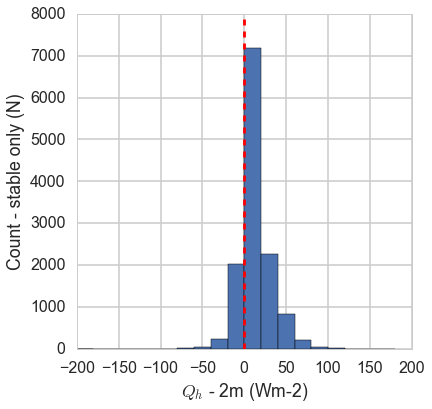

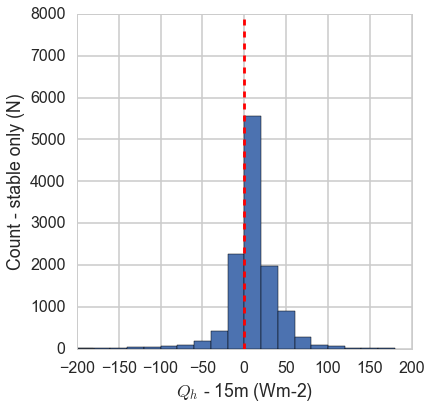

In [12]:
os.chdir(dirPrint)
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(-fluxObs.w_tc__2m_M[(RiBulk_2m_theta.values > 0)
                            & (~np.isnan(RiBulk_2m_theta)).values],
        bins=np.arange(-200,200,20));
ax.plot([0, 0], [0, 8000], 'r--')
ax.set_xlabel('$Q_h$ - 2m (Wm-2)')
ax.set_ylabel('Count - stable only (N)')
fig.savefig('SCP_2m.Qh_Hist.pdf')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(-fluxObs.w_tc__10m_M[(RiBulk_15m_theta.values > 0)
                             & (~np.isnan(RiBulk_15m_theta)).values
                             & (~np.isnan(fluxObs.w_tc__10m_M)).values],
        bins=np.arange(-200,200,20));
ax.plot([0, 0], [0, 8000], 'r--')
ax.set_xlabel('$Q_h$ - 15m (Wm-2)')
ax.set_ylabel('Count - stable only (N)')
fig.savefig('SCP_15m.Qh_Hist.pdf')


In [16]:
print((fluxObs['w_tc__10m_M'].where(RiBulk_15m_theta > 0) > 0).mean(dim='time'))
print((fluxObs['w_tc__2m_M'].where(RiBulk_2m_theta > 0) > 0).mean(dim='time'))

print((fluxObs['w_tc__10m_M'][(RiBulk_15m_theta.values > 0)
                             & (~np.isnan(RiBulk_15m_theta)).values
                             & (~np.isnan(fluxObs.w_tc__10m_M)).values] > 0).mean(dim='time'))
print((fluxObs['w_tc__2m_M'][(RiBulk_2m_theta.values > 0)
                             & (~np.isnan(RiBulk_2m_theta)).values
                             & (~np.isnan(fluxObs.w_tc__2m_M)).values] > 0).mean(dim='time'))

<xarray.DataArray ()>
array(0.15591242283950618)
Coordinates:
    altitude   float64 1.645e+03
    station    |S6 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
<xarray.DataArray ()>
array(0.11058063271604938)
Coordinates:
    altitude   float64 1.645e+03
    station    |S6 b'M21'
    longitude  float64 -104.8
    latitude   float64 40.81
<xarray.DataArray 'w_tc__10m_M' ()>
array(0.2653697775588935)
<xarray.DataArray 'w_tc__2m_M' ()>
array(0.17904271101741234)


There is no obvious change in the stability, as measured by the bulk Richardson number, when using the potential temperature. Hurray?

## Spatial variability in bulk Richardson #

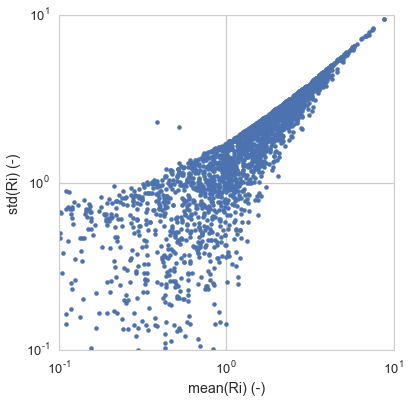

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.loglog(np.log(Atower.RiBulk_5m.mean(dim='station')), np.log(Atower.RiBulk_5m.std(dim='station')), '.')
ax.set_ylim(0.1,10)
ax.set_xlim(0.1,10)
ax.set_ylabel('std(Ri) (-)')
ax.set_xlabel('mean(Ri) (-)')

The spatial variation in $Ri$ is log-linear with the mean $Ri$  

But, what if we use the gradient $Ri$ number instead? In this case, we won't be assuming a constant surface temperature, which seesm like a more reasonable assumption.

In [52]:
gradRiA = np.zeros_like(Atower.sel(station='A1').T_0_5m.values)
for n, t in enumerate(Atower.time.values):
    T5 = Atower.sel(station='A1').T_0_5m.values[n]
    T1 = Atower.sel(station='A1').T_1m.values[n]
    U5 = Atower.sel(station='A1').UBar_5m.values[n]
    U1 = Atower.sel(station='A1').UBar_1m.values[n]
    gradRiA[n], _ = gradRichardson(np.array((T5, T1)), np.array((U5, U1)), np.array((5., 1.)))

Did some plotting with these results, but they don't seem particularly useful. Too bad.